In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay)
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("../data/chemtastes_features_nonpep.csv")

In [78]:
df.tail(5)

,smiles,taste,superclass,class,subclass,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
2979,CC(CCC(O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C...,Non-bitterness,Lipids and lipid-like molecules,Steroids and steroid derivatives,Cucurbitacins,14.190726,0.039282,-1.079444,0.448076,45.617647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2980,OCC(O)C(O)C(=O)CO,Non-bitterness,Organic oxygen compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates,10.341019,0.701481,-1.685185,0.348360,16.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2981,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Non-bitterness,Organoheterocyclic compounds,Oxanes,Unknown,10.463809,0.628475,-4.681600,0.515767,42.866667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2982,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Non-bitterness,Phenylpropanoids and polyketides,Coumarins and derivatives,Furanocoumarins,12.371043,0.297203,-0.756085,0.472125,16.884615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,OCC(O)C(O)C(O)C(O)C(O)CO,Non-bitterness,Organic oxygen compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates,9.147037,0.791501,-1.847870,0.236348,22.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
labels = df["taste"].map(lambda x: "Bitterness"
                         if x == "Bitterness" else "Non-Bitterness")
features = df.iloc[:, 6:]

In [80]:
feature_train, feature_test, label_train, label_test = train_test_split(
    features, labels, test_size=0.2, random_state=527
)

In [83]:
rf_clf = RandomForestClassifier(n_estimators=250)
rf_clf.fit(feature_train, label_train)

RandomForestClassifier(n_estimators=250)

In [84]:
pred = rf_clf.predict(feature_test)

In [85]:
print(classification_report(label_test, pred, digits=3))

                precision    recall  f1-score   support

    Bitterness      0.892     0.879     0.886       282
Non-Bitterness      0.893     0.905     0.899       315

      accuracy                          0.893       597
     macro avg      0.893     0.892     0.892       597
  weighted avg      0.893     0.893     0.893       597



In [86]:
importance_score = rf_clf.feature_importances_

feature_importance = pd.DataFrame({
    'Descriptor': feature_train.columns,
    'Importance': importance_score
}).sort_values('Importance', ascending=False)

In [87]:
feature_importance[:20]

,Descriptor,Importance
1,MinEStateIndex,0.038333
9,BCUT2D_MWHI,0.033033
30,PEOE_VSA8,0.029112
62,VSA_EState8,0.028849
6,MinPartialCharge,0.027719
61,VSA_EState7,0.025612
7,MaxAbsPartialCharge,0.025374
14,BCUT2D_MRHI,0.022156
2,qed,0.021414
15,BCUT2D_MRLOW,0.020308


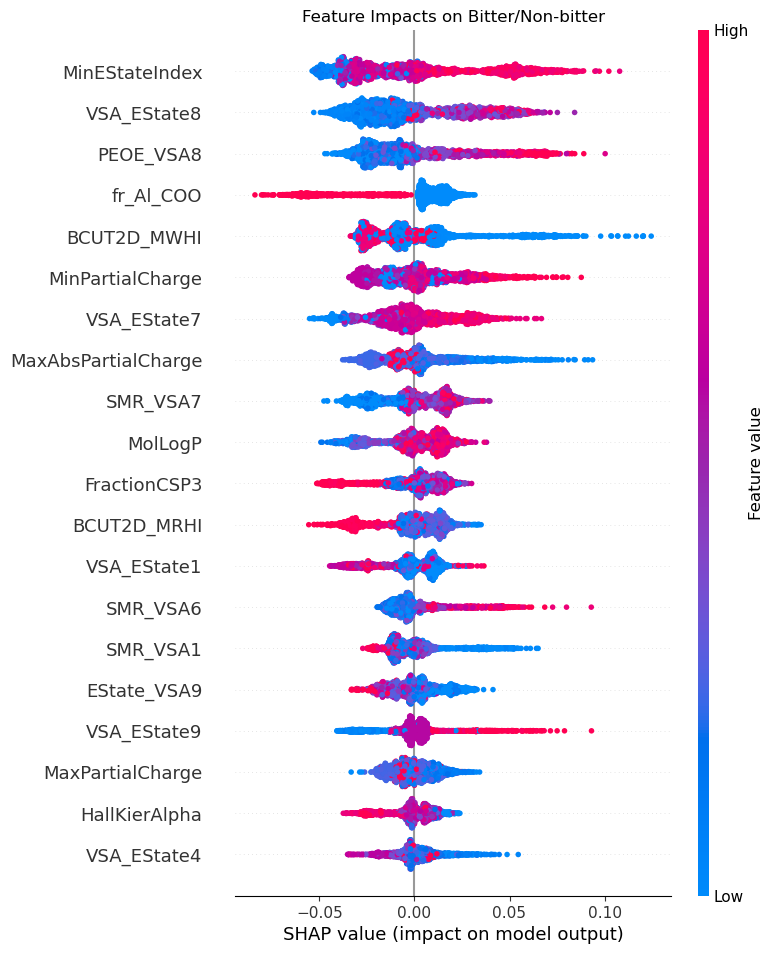

In [94]:
shap_explainer = shap.TreeExplainer(rf_clf)
shap_values = shap_explainer.shap_values(feature_train)

shap.summary_plot(shap_values[:, :, 0], feature_train, show=False)
plt.title("Feature Impacts on Bitter/Non-bitter")
plt.show()

# Error analysis

Text(0.5, 1.0, 'Confusion Matrix for Bitter/Non-bitter Random Forest')

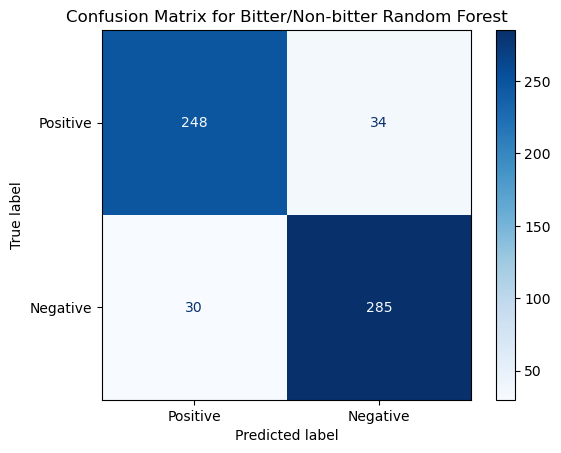

In [90]:
cm = confusion_matrix(label_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Bitter/Non-bitter Random Forest")

Text(0, 0.5, 'True Positive Rate')

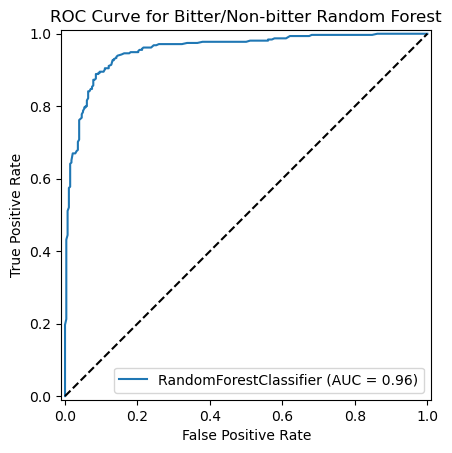

In [91]:
pred_prob = rf_clf.predict_proba(feature_test)[:, 1]

RocCurveDisplay.from_estimator(rf_clf, feature_test, label_test)
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Bitter/Non-bitter Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")